In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\Circuit Recognition.v6-main-dataset.voc'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import models
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree
from PIL import Image
from tqdm import tqdm
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
sns.set_style('darkgrid')


In [3]:

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')

Modules loaded


In [4]:
annotations_directory = 'C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\dataset\\annotations'
images_directory = 'C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\dataset\\images'

In [5]:
import shutil

train_dir = 'C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\Circuit Recognition.v6-main-dataset.voc\\train'
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), annotations_directory)
for filename in os.listdir(train_dir):
    if filename.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, filename))
        image = image.convert("RGB")
        new_filename = os.path.splitext(filename)[0] + ".jpeg"
        image.save(os.path.join(images_directory, new_filename), "JPEG")

In [6]:
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)

    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag:
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))

        if 'object' in element.tag:
            for attribute in list(element):

                if 'name' in attribute.tag:
                    name = attribute.text
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height]
                    information['file'] += [annotation.split('\\')[-1][0:-4]]

                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [7]:
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height
0,213,18,279,64,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
1,211,63,269,98,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
2,203,125,280,167,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
3,196,167,273,205,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
4,194,230,270,267,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
5,201,266,262,305,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
6,61,86,180,114,c,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
7,7,115,80,158,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
8,3,158,79,198,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320
9,47,286,188,319,acv,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320


In [8]:
# Add Annotation and Image File Names
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.jpeg'

In [9]:
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,213,18,279,64,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
1,211,63,269,98,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
2,203,125,280,167,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
3,196,167,273,205,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
4,194,230,270,267,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
5,201,266,262,305,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
6,61,86,180,114,c,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
7,7,115,80,158,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
8,3,158,79,198,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
9,47,286,188,319,acv,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg


In [10]:
x=len(annotations_info_df)

In [11]:
x

17382

In [12]:

def render_image(image_path):
    image = cv2.imread(image_path)
    img=image_path.split('\\')[-1]
    #print(image.shape)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_box=[]
    for i in annotations_info_df[annotations_info_df['image_file']==img].index:
        (x,y,width,height)=(annotations_info_df.loc[i].xmin,annotations_info_df.loc[i].ymin,
                        annotations_info_df.loc[i].xmax,annotations_info_df.loc[i].ymax)
        bound_box.append((x,y,width,height))
        if annotations_info_df.loc[i].label=='r':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 200, 0), 2)
            cv2.putText(image, org = (x-8 , y-8), text = "Rezistenta",
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (0, 200, 0))
        elif annotations_info_df.loc[i].label=='i':
            cv2.rectangle(image, (x,y), (x+width, y+height), (255, 255, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'Bobina',
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        elif annotations_info_df.loc[i].label=='c':
            cv2.rectangle(image, (x,y), (x+width, y+height), (200, 0, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'Condensator',
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        elif annotations_info_df.loc[i].label=='l-':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 0, 200), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'l-',
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        elif annotations_info_df.loc[i].label=='acv':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 255, 255), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'acv',
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        elif annotations_info_df.loc[i].label=='l':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 255, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'l',
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        else:
            cv2.rectangle(image, (x,y), (x+width, y+height), (200, 0, 200), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'v',
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (200, 0, 0))

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    return bound_box,image

In [13]:
images_with_annotations = {}

for image_filename, count in annotations_info_df['image_file'].value_counts().items():
    clean_image_filename = image_filename.split('-')[0] + '.jpeg'  # Extract and clean the image filename
    if count > 1:
        images_with_annotations[image_filename] = count


In [14]:
len(images_with_annotations)

3109

In [15]:
annotations_info_df.loc[0]

xmin                                                            213
ymin                                                             18
xmax                                                            279
ymax                                                             64
label                                                             l
file                    251_png.rf.b8bb9c9f4c18fda44c0739864189191d
width                                                           320
height                                                          320
annotation_file     251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml
image_file         251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
Name: 0, dtype: object

In [16]:
annotations_info_df.head(10)


,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,213,18,279,64,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
1,211,63,269,98,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
2,203,125,280,167,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
3,196,167,273,205,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
4,194,230,270,267,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
5,201,266,262,305,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
6,61,86,180,114,c,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
7,7,115,80,158,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
8,3,158,79,198,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg
9,47,286,188,319,acv,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg


Processing image: C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\dataset\images\275_png.rf.527d675eb217e4ec943e0a160fca92e1.jpeg


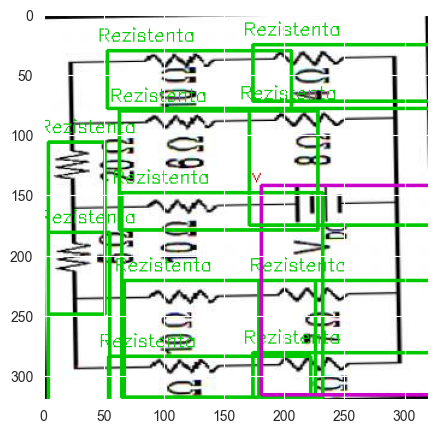

Processing image: C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\dataset\images\275_png.rf.01b41ba7597343c6b31af7367d4e7540.jpeg


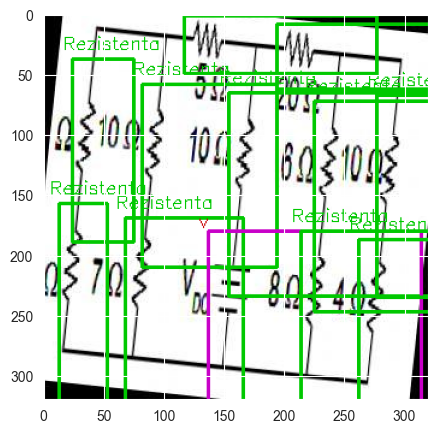

Processing image: C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\dataset\images\275_png.rf.7173adc9af2d97a10d94e9a748134e96.jpeg


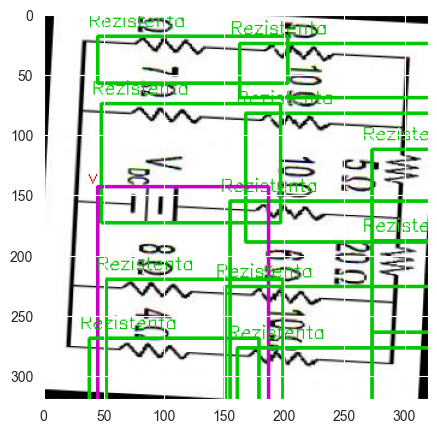

In [17]:
for image_filename in list(images_with_annotations.keys())[:3]:
    image_path = os.path.join(images_directory, image_filename)
    print("Processing image:", image_path)
    render_image(image_path)

Image path: C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\dataset\images\275_png.rf.527d675eb217e4ec943e0a160fca92e1.jpeg


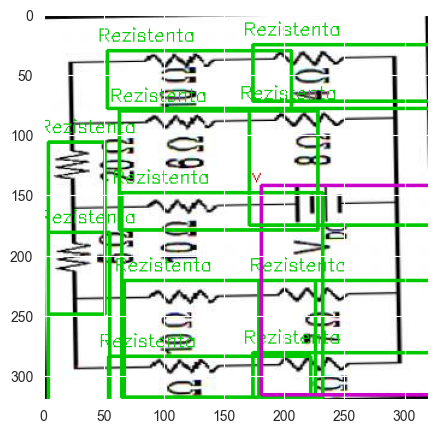

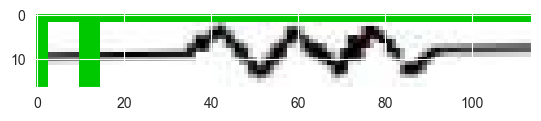

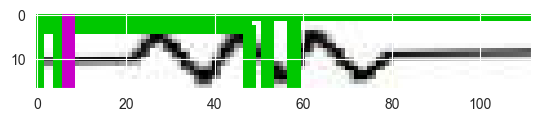

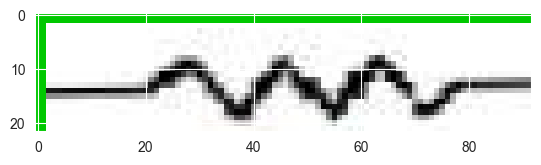

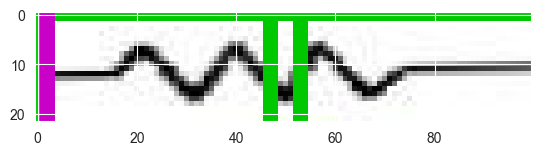

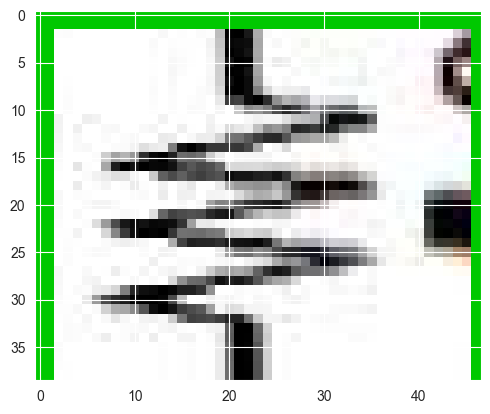

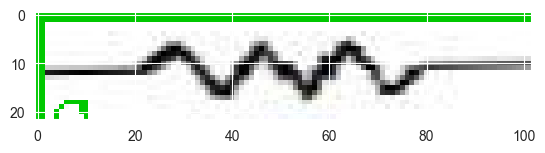

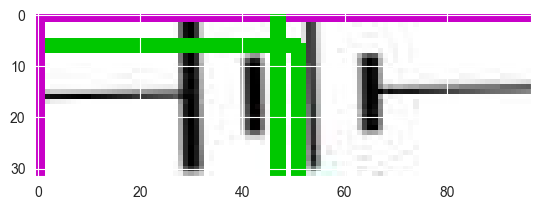

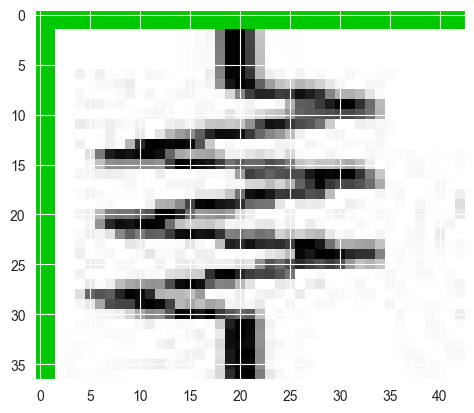

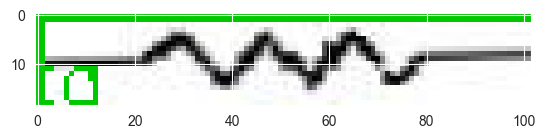

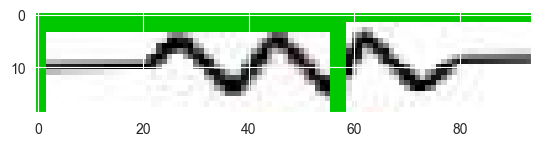

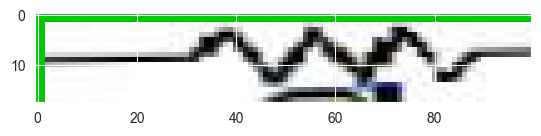

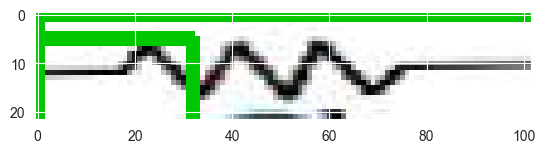

Image path: C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\dataset\images\275_png.rf.01b41ba7597343c6b31af7367d4e7540.jpeg


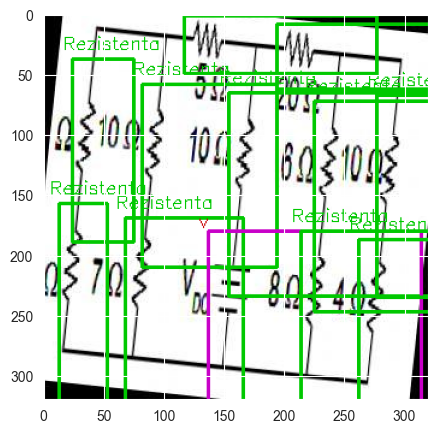

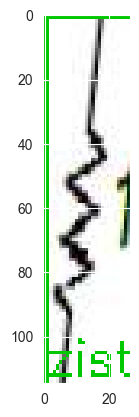

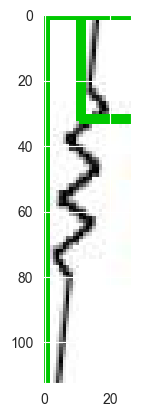

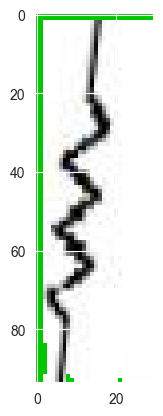

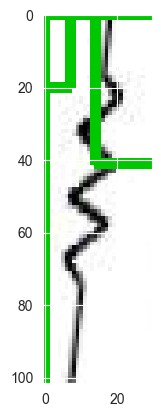

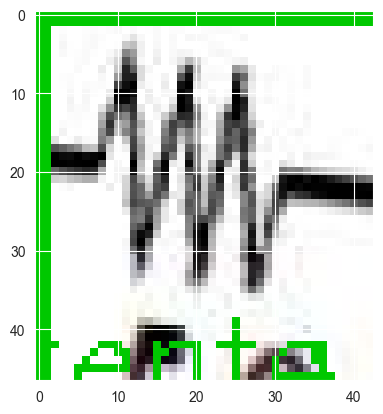

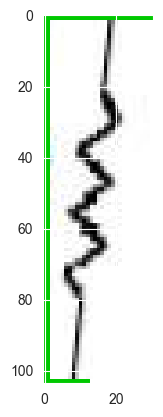

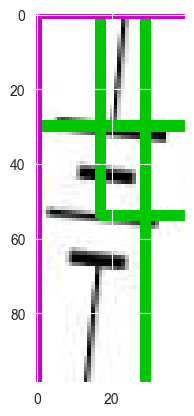

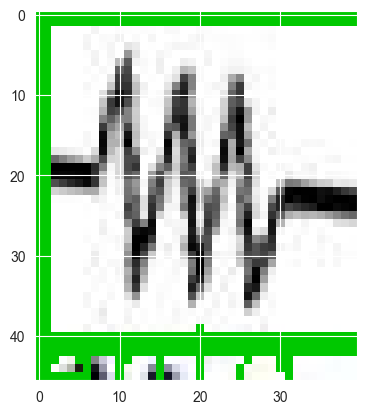

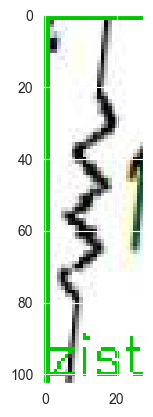

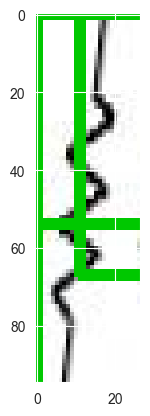

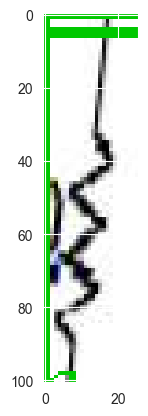

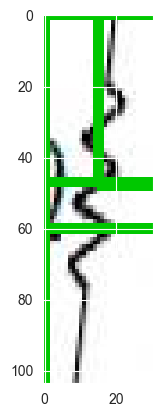

Image path: C:\Users\Ionut Halmagiu\PycharmProjects\pythonProject4\dataset\images\275_png.rf.7173adc9af2d97a10d94e9a748134e96.jpeg


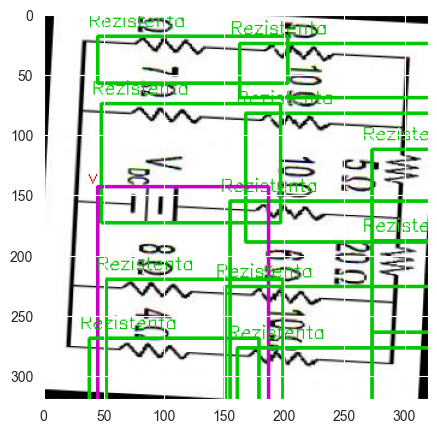

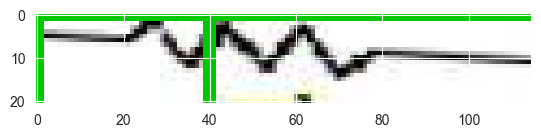

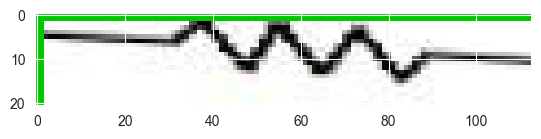

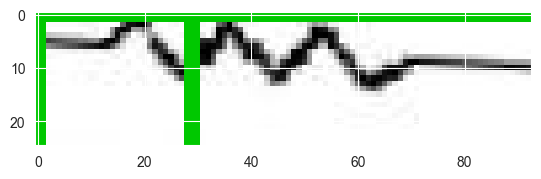

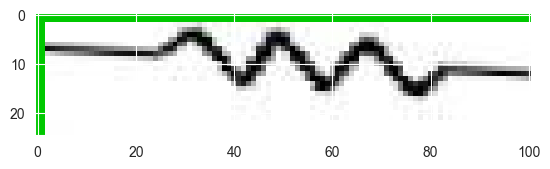

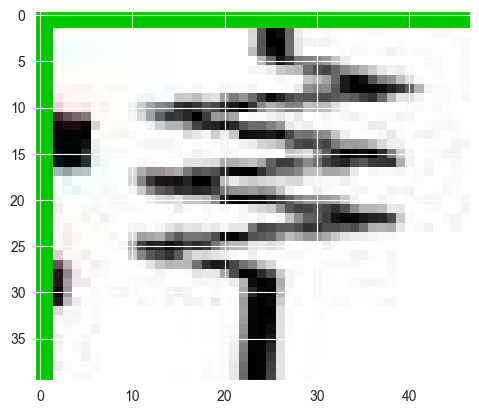

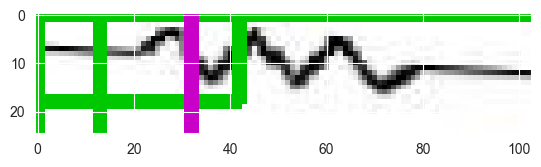

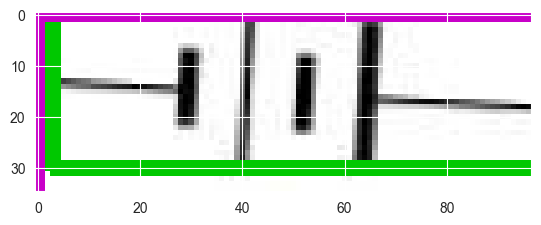

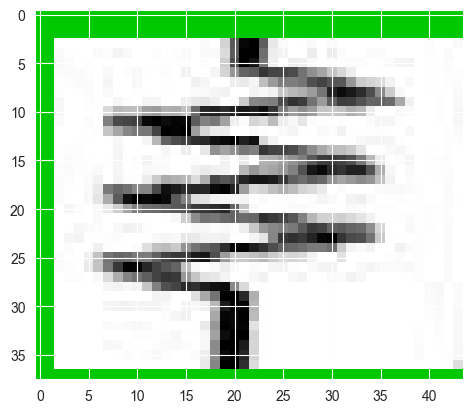

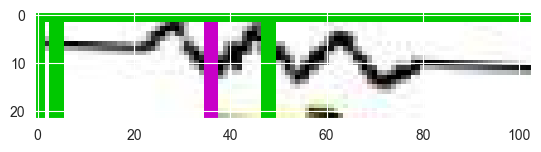

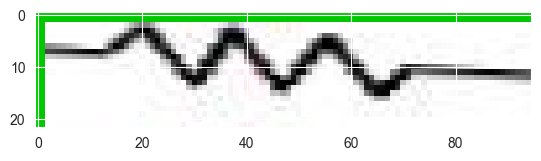

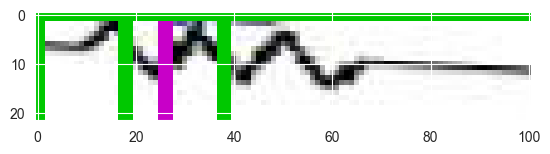

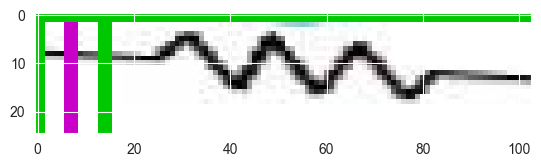

In [18]:
images_with_annotations_list = list(images_with_annotations.keys())[:3]

for image_filename in images_with_annotations_list:
    image_path = os.path.join(images_directory, image_filename)
    print("Image path:", image_path)

    if not os.path.exists(image_path):
        print("Error: Image not found at", image_path)
        continue

    bound_box, image = render_image(image_path)
    
    if image is None:
        print("Error: Unable to render image at", image_path)
        continue
    
    if bound_box is None:
        print("Error: Unable to obtain bounding box information for", image_path)
        continue
    
    # Now you can use bound_box and image to further process the image
    for i in bound_box:
        cropped = image[i[1]:i[3], i[0]:i[2]]
        plt.imshow(cropped)
        plt.show()

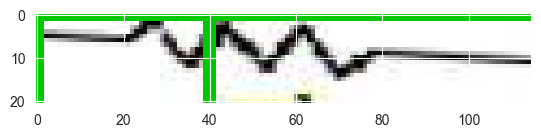

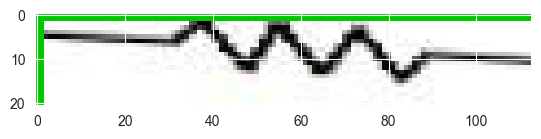

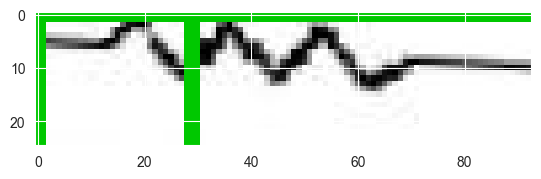

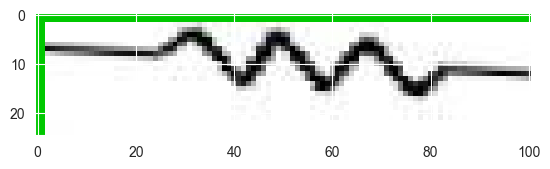

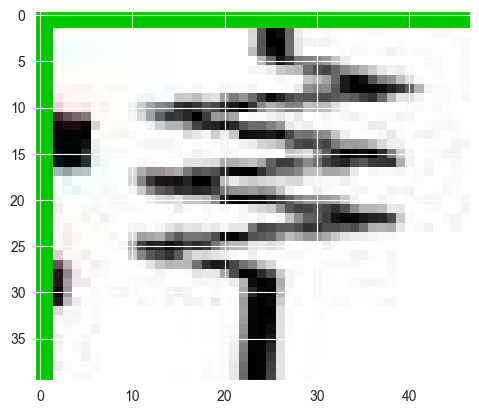

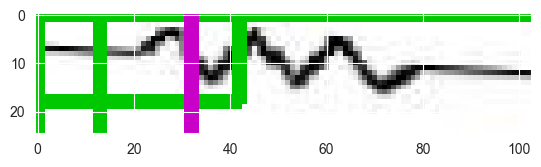

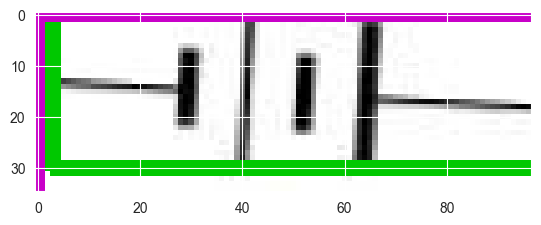

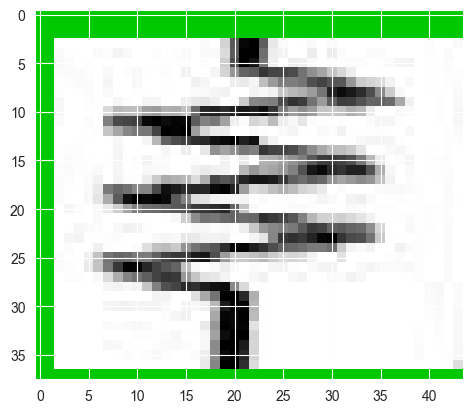

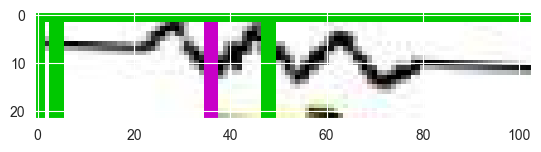

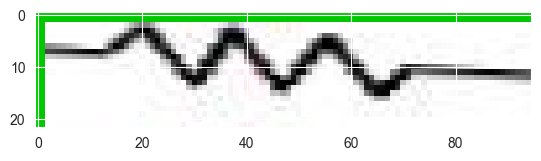

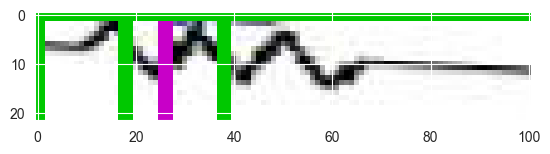

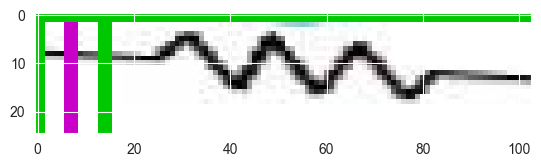

In [19]:
for i in bound_box:
    cropped = image[i[1]:i[3],i[0]:i[2]]
    plt.imshow(cropped)
    plt.show()

In [20]:
annotations_info_df['cropped_image_file'] = annotations_info_df['file']
annotations_info_df.head(10)


,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,213,18,279,64,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
1,211,63,269,98,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
2,203,125,280,167,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
3,196,167,273,205,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
4,194,230,270,267,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
5,201,266,262,305,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
6,61,86,180,114,c,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
7,7,115,80,158,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
8,3,158,79,198,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d
9,47,286,188,319,acv,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d


In [21]:
directory = 'cropped_images1000'
parent_directory = 'C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\working1'
path = os.path.join(parent_directory, directory)


In [22]:
for i in range(len(annotations_info_df)):
    # Get The File Path and Read The Image
    image_filepath = os.path.join('dataset\\images\\', annotations_info_df['image_file'].iloc[i])
    if os.path.exists(image_filepath):
        image = cv2.imread(image_filepath)
        if image is not None:
            # Set The Cropped Image File Name
            # Set The Cropped Image File Name
            cropped_image_filename = annotations_info_df.at[i, 'cropped_image_file'] + '-' + str(i) + '.jpeg'

            # Update the DataFrame with the new filename
            annotations_info_df.at[i, 'cropped_image_file'] = cropped_image_filename

            # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
            xmin = annotations_info_df.at[i, 'xmin']
            ymin = annotations_info_df.at[i, 'ymin']
            xmax = annotations_info_df.at[i, 'xmax']
            ymax = annotations_info_df.at[i, 'ymax']

            # Crop The Image Based on The Values Above
            cropped_image = image[ymin:ymax, xmin:xmax]

            # Specify the complete path for saving cropped images
            cropped_image_directory = os.path.join('working1\\cropped_images1000', cropped_image_filename)
            cv2.imwrite(cropped_image_directory, cropped_image)
        else:
            print(f"Error reading image: {image_filepath}")
    else:
        print(f"Image file not found: {image_filepath}")

In [23]:
#annotations_info_df['label'] = labels
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,213,18,279,64,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-0.jpeg
1,211,63,269,98,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-1.jpeg
2,203,125,280,167,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-2.jpeg
3,196,167,273,205,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-3.jpeg
4,194,230,270,267,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-4.jpeg
5,201,266,262,305,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-5.jpeg
6,61,86,180,114,c,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-6.jpeg
7,7,115,80,158,l,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-7.jpeg
8,3,158,79,198,r,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-8.jpeg
9,47,286,188,319,acv,251_png.rf.b8bb9c9f4c18fda44c0739864189191d,320,320,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.xml,251_png.rf.b8bb9c9f4c18fda44c0739864189191d.jpeg,251_png.rf.b8bb9c9f4c18fda44c0739864189191d-9.jpeg


In [24]:
classes=annotations_info_df['label'].unique()

In [25]:
labels=annotations_info_df['label']
annotations_info_df.drop(['label'],axis=1,inplace=True)

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(annotations_info_df,labels,test_size=0.25,stratify=labels,random_state=42)

In [27]:
print(X_train.shape,X_test.shape)

(13036, 10) (4346, 10)


In [28]:
Y_train.value_counts()

label
r      7270
i      1403
l      1333
c      1270
acv     934
v       824
l-        2
Name: count, dtype: int64

In [ ]:
image_width = []   # A list to store the widths of the images
image_height = []  # A list to store the heights of the images

# Iterate through each row in X_train
for i in range(len(X_train)):
    cropped_image_path = os.path.join('C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\working1\\cropped_images1000', X_train['cropped_image_file'].iloc[i])
    print(f"Reading image: {cropped_image_path}")

    try:
        if os.path.exists(cropped_image_path):
            # Read the cropped image
            cropped_image = cv2.imread(cropped_image_path)
            if cropped_image is not None:
                # Append the width and height of the image to the respective lists
                image_width.append(cropped_image.shape[0])  # Width is the number of rows
                image_height.append(cropped_image.shape[1])  # Height is the number of columns
            else:
                print(f"Error reading image: {cropped_image_path}")
                continue
        else:
            print(f"Image file not found: {cropped_image_path}")
            continue
    except Exception as e:
        print(f"An error occurred: {e}")
        continue

In [30]:
print('IMAGE WIDTH')
print(f'Min: {min(image_width)}')
print(f'Max: {max(image_width)}')
print(f'Mean: {np.mean(image_width)}')
print(f'Median: {np.median(image_width)}')
print('IMAGE HEIGHT')
print(f'Min: {min(image_height)}')
print(f'Max: {max(image_height)}')
print(f'Mean: {np.mean(image_height)}')
print(f'Median: {np.median(image_height)}')

IMAGE WIDTH
Min: 10
Max: 254
Mean: 43.41408407486959
Median: 38.0
IMAGE HEIGHT
Min: 9
Max: 252
Mean: 43.838677508438174
Median: 39.0


In [31]:
image_target_size = (int(60), int(60))
image_target_size

(60, 60)

In [32]:
X_train['label']=Y_train
X_test['label']=Y_test

In [33]:
#X_train

In [ ]:
!pip install Keras-Preprocessing

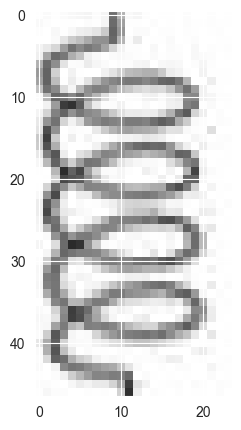

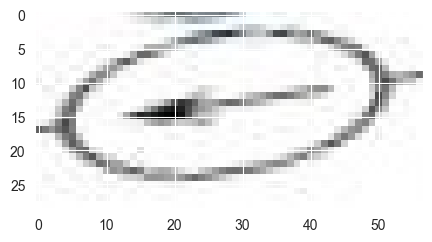

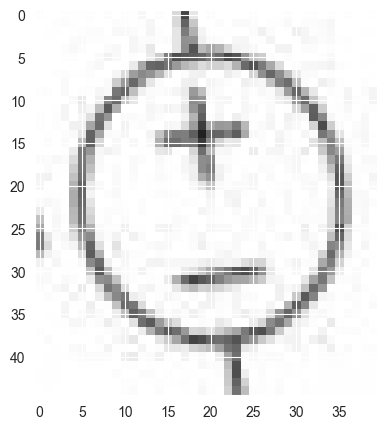

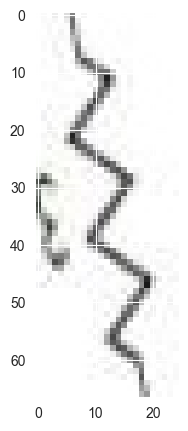

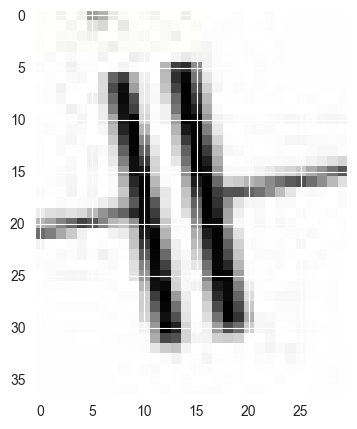

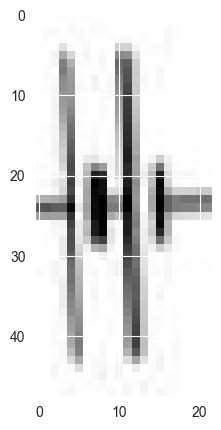

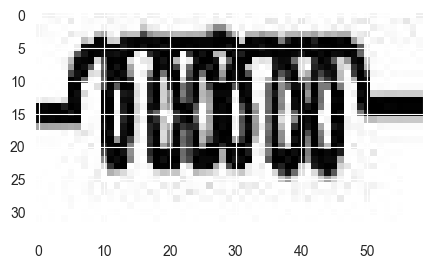

In [35]:
import random

# Select one image for each class
unique_classes = X_train['label'].unique()
selected_images = []

for class_label in unique_classes:
    class_samples = X_train[X_train['label'] == class_label]
    random_index = random.randint(0, len(class_samples) - 1)
    selected_image_path = os.path.join('working1\\cropped_images1000', class_samples.iloc[random_index]['cropped_image_file'])
    selected_images.append(selected_image_path)

# Display the selected images
for image_path in selected_images:
    render_image(image_path)

In [36]:
length=len(X_test)

In [37]:
len(X_train)

13036

In [38]:
len(X_test)

4346

In [39]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale = 1. / 255.)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = 'working1\\cropped_images1000',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 13036 validated image filenames belonging to 7 classes.


In [40]:
test_image_generator = ImageDataGenerator(rescale = 1. / 255.)

test_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = 'working1\\cropped_images1000',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 4346 validated image filenames belonging to 7 classes.


In [41]:
test_generator.class_indices

{'acv': 0, 'c': 1, 'i': 2, 'l': 3, 'l-': 4, 'r': 5, 'v': 6}

In [42]:
class_ind=train_generator.class_indices

In [43]:
test_generator.class_indices

{'acv': 0, 'c': 1, 'i': 2, 'l': 3, 'l-': 4, 'r': 5, 'v': 6}

In [44]:
conv_base = tf.keras.applications.VGG16(include_top = False,   
                                            weights = 'imagenet',
                                            input_shape = (60, 60, 3) 
                                           )

In [45]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 60, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 60, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 30, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 30, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 30, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 15, 15, 128)       0     

In [46]:
modelVGG16 = models.Sequential() 
modelVGG16.add(conv_base)  
modelVGG16.add(layers.Flatten())
    
modelVGG16.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(0.001)))
modelVGG16.add(layers.Dropout(rate=0.3, name='dropout_1')) 
modelVGG16.add(layers.Activation(activation='relu', name='activation_1'))
    
modelVGG16.add(layers.Dense(7, activation='softmax', name='dense_output'))
modelVGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 14980935 (57.15 MB)
Trainable params: 1498

In [47]:
conv_base.trainable = False
modelVGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 14980935 (57.15 MB)
Trainable params: 2662

In [48]:
print(modelVGG16.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 14980935 (57.15 MB)
Trainable params: 2662

In [49]:
keras.utils.plot_model(modelVGG16, show_shapes=True, dpi=76, to_file='vgg16-transfer-learning.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [50]:
conv_base1=conv_base = tf.keras.applications.ResNet50(include_top=False,
                                          weights='imagenet',
                                          input_shape=(60, 60, 3))

In [51]:
conv_base1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 60, 60, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 66, 66, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 30, 30, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 30, 30, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [52]:
modelResnet50 = models.Sequential()
modelResnet50.add(conv_base1)
modelResnet50.add(layers.Flatten())

modelResnet50.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(0.001)))
modelResnet50.add(layers.Dropout(rate=0.3, name='dropout_1'))
modelResnet50.add(layers.Activation(activation='relu', name='activation_1'))

modelResnet50.add(layers.Dense(7, activation='softmax', name='dense_output'))
modelResnet50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 27786119 (106.00 MB)
Trainable params: 2

In [53]:
conv_base1.trainable = False
modelResnet50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 27786119 (106.00 MB)
Trainable params: 4

In [54]:
print(modelResnet50.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 27786119 (106.00 MB)
Trainable params: 4

In [56]:
model_selected=modelVGG16
print(model_selected.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 14980935 (57.15 MB)
Trainable params: 2662

In [57]:
filepath = "saved_models\\all epochs\\resnet50-2\\transfer_learning_epoch-unbalanced_{epoch:02d}_{val_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath,
                                       monitor='val_categorical_accuracy',
                                       save_best_only=False) #saves the results
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)
callbacks_list = [checkpoint, red_lr] #saves the models and the adjustment

In [58]:
model_selected.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(learning_rate=0.001),
                metrics = ['accuracy'])

history_1 = model_selected.fit(train_generator, epochs = 30, steps_per_epoch = len(train_generator),
                     validation_data = test_generator, validation_steps = len(test_generator), callbacks = callbacks_list)


Epoch 1/30
  4/408 [..............................] - ETA: 1:23 - loss: 1.9671 - accuracy: 0.5000

KeyboardInterrupt: 

In [61]:
model = models.load_model(filepath='C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\saved_models\\vgg16-classification2.h5')


In [78]:
import pickle
with open('C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\saved_models\\pkl\\vgg16-2.pkl.pkl', 'wb') as f:
    pickle.dump(history_1.history, f)

NameError: name 'history_1' is not defined

In [79]:
# Load scores
import pandas as pd
import pickle
with open('C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\saved_models\\pkl\\vgg16-2.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
print(scores)
scores = pd.DataFrame(scores, index=range(1,31))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
{'loss': [0.4142281413078308, 0.2220497727394104, 0.194351926445961, 0.18499630689620972, 0.17988039553165436, 0.17016543447971344, 0.17107878625392914, 0.16298113763332367, 0.1677040308713913, 0.16149312257766724, 0.13142497837543488, 0.12246214598417282, 0.1161215603351593, 0.11487170308828354, 0.10980089008808136, 0.10968148708343506, 0.11026602983474731, 0.10791285336017609, 0.10851000249385834, 0.10914372652769089, 0.10966069251298904, 0.10924264788627625, 0.10935257375240326, 0.10829074680805206, 0.10984537750482559, 0.10788522660732269, 0.10971804708242416, 0.109225332736969, 0.10906639695167542, 0.10882680118083954], 'accuracy': [0.9185332655906677, 0.9608008861541748, 0.9627953171730042, 0.9627186059951782, 0.9639459848403931, 0.9664007425308228, 0.964022696018219, 0.9686253666877747, 0.966093897819519, 0.9687020778656006, 0.9795182347297668, 0.980438768863678, 0.9808223247528076, 0.9810524582862854, 0.982816815

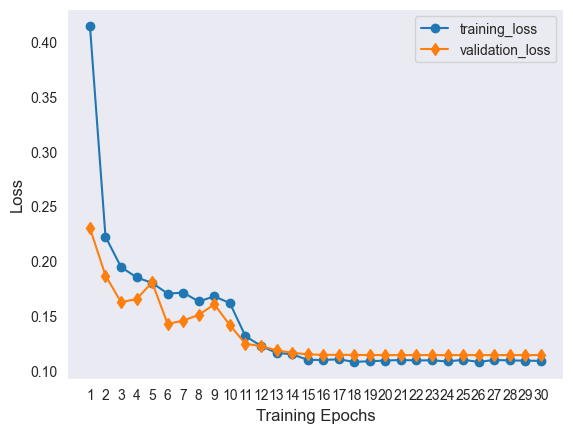

In [80]:
plt.xticks(range(1,31))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

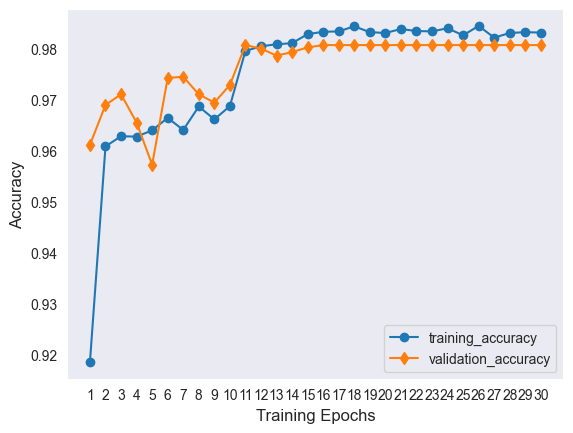

In [81]:
plt.xticks(range(1,31))
plt.plot(scores['accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

In [63]:
model = model_selected.save('C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\saved_models\\resnet-classification2.h5')

In [83]:
model = models.load_model(filepath='C:\\Users\\Ionut Halmagiu\\PycharmProjects\\pythonProject4\\saved_models\\vgg16-classification2.h5')

In [84]:
cropped_image_directory = os.path.join('working1\\cropped_images1000', cropped_image_filename)


In [85]:
image=cv2.imread(cropped_image_directory)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

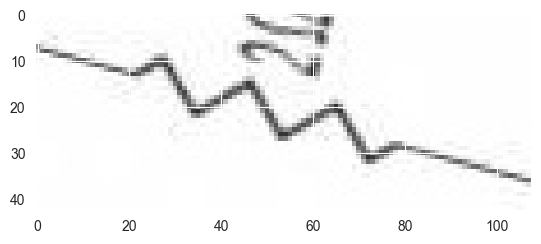

In [86]:
plt.imshow(image)

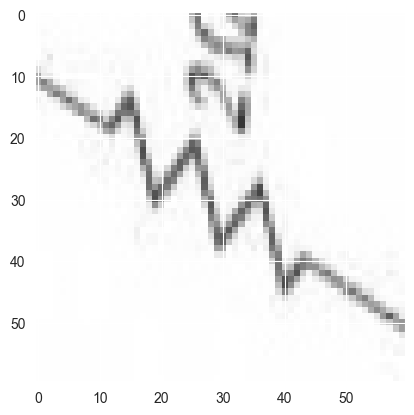

In [87]:
bigger = cv2.resize(image, (60,60))
plt.imshow(bigger)

In [88]:
bigger=bigger/255

In [89]:
bigger=bigger.reshape(1,60,60,3)

In [90]:
class_ind

{'acv': 0, 'c': 1, 'i': 2, 'l': 3, 'l-': 4, 'r': 5, 'v': 6}

In [91]:
pred_val=np.argmax(model_selected.predict(bigger))

1/1 [==============================] - 0s 70ms/step


In [92]:
y_pred=[]
for i,j in class_ind.items():
    if pred_val==j:
        y_pred.append(i)

In [93]:
len(y_pred)

1

In [94]:
y_pred

['r']

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_indices = []  # To store predicted class indices

# Iterate through X_test and predict labels
for i in range(len(X_test)):
    # Get the cropped image filename
    cropped_image_filename = X_test['cropped_image_file'].iloc[i]

    # Construct the full path to the image
    cropped_image_path = os.path.join('working1\\cropped_images1000', cropped_image_filename)

    # Load and preprocess the image
    image = cv2.imread(cropped_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bigger = cv2.resize(image, (60, 60))
    bigger = bigger / 255
    bigger = bigger.reshape(1, 60, 60, 3)

    # Predict the label
    pred_val1 = np.argmax(model_selected.predict(bigger))

    # Append the predicted class index
    y_pred_indices.append(pred_val1)

# Get the true class indices for the test set
y_true_indices = [class_ind[label] for label in Y_test]

# Create a confusion matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

# Get class labels for plotting
class_labels = list(class_ind.keys())

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate accuracy and F1-score
accuracy = accuracy_score(y_true=y_true_indices, y_pred=y_pred_indices)
f1_score_macro = f1_score(y_true=y_true_indices, y_pred=y_pred_indices, average='macro')

print('Test Set Accuracy: {:.2f}'.format(accuracy))
print('Test Set F1-Score (Macro): {:.2f}'.format(f1_score_macro))
class_report = classification_report(y_true_indices, y_pred_indices, target_names=class_labels)

# Print the classification report
print("Classification Report:\n", class_report)

1/1 [==============================] - 0s 120ms/step


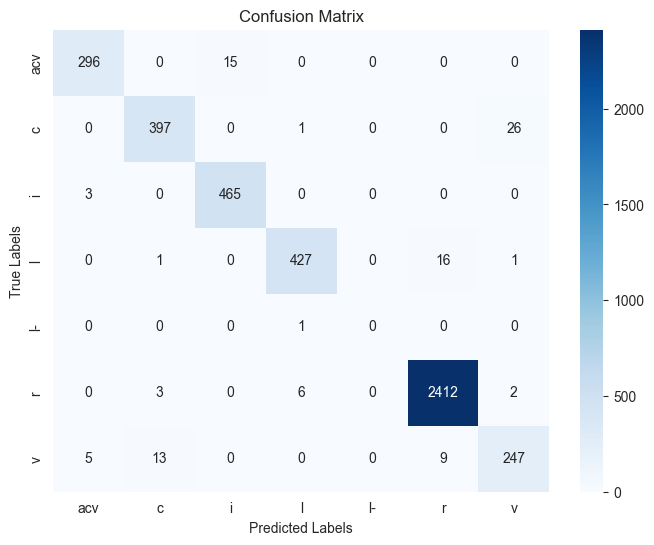

Test Set Accuracy: 0.98
Test Set F1-Score (Macro): 0.82
Classification Report:
               precision    recall  f1-score   support

         acv       0.97      0.95      0.96       311
           c       0.96      0.94      0.95       424
           i       0.97      0.99      0.98       468
           l       0.98      0.96      0.97       445
          l-       0.00      0.00      0.00         1
           r       0.99      1.00      0.99      2423
           v       0.89      0.90      0.90       274

    accuracy                           0.98      4346
   macro avg       0.82      0.82      0.82      4346
weighted avg       0.98      0.98      0.98      4346


In [95]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_indices = []  # To store predicted class indices

# Iterate through X_test and predict labels
for i in range(len(X_test)):
    # Get the cropped image filename
    cropped_image_filename = X_test['cropped_image_file'].iloc[i]

    # Construct the full path to the image
    cropped_image_path = os.path.join('working1\\cropped_images1000', cropped_image_filename)

    # Load and preprocess the image
    image = cv2.imread(cropped_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bigger = cv2.resize(image, (60, 60))
    bigger = bigger / 255
    bigger = bigger.reshape(1, 60, 60, 3)

    # Predict the label
    pred_val1 = np.argmax(model.predict(bigger))

    # Append the predicted class index
    y_pred_indices.append(pred_val1)

# Get the true class indices for the test set
y_true_indices = [class_ind[label] for label in Y_test]

# Create a confusion matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

# Get class labels for plotting
class_labels = list(class_ind.keys())

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate accuracy and F1-score
accuracy = accuracy_score(y_true=y_true_indices, y_pred=y_pred_indices)
f1_score_macro = f1_score(y_true=y_true_indices, y_pred=y_pred_indices, average='macro')

print('Test Set Accuracy: {:.2f}'.format(accuracy))
print('Test Set F1-Score (Macro): {:.2f}'.format(f1_score_macro))
class_report = classification_report(y_true_indices, y_pred_indices, target_names=class_labels)

# Print the classification report
print("Classification Report:\n", class_report)